# <center> Paper Experimental Results </center>

We provide in this notebook a set of routines to generate and reproduce the plots observed in the original paper. 

In [8]:
# Libraries 
import os
import torch
import argparse
import numpy as np
from glob import glob
import torch.utils.data
from torch import nn, optim
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
%matplotlib inline

#Set reproducibility seeed
torch.manual_seed(1)

## VLB Evaluation
The point of this experiment is to evaluate the Variational Lower Bound (VLB) for our Variational Sparse Coding (VSC) model given different sparcity values  $\alpha$, also for a Variational Autoencoder (VAE) for varying number of latent dimension. 

The following commands were executed in order to obtain the trained models needed for our future plots. 

### Mnist 

- ** python vae-mnist.py --log-interval 100 --latent 20 **
- ** python vae-mnist.py --log-interval 100 --latent 50 **
- ** python vae-mnist.py --log-interval 100 --latent 75 **
- ** python vae-mnist.py --log-interval 100 --latent 100 **
- ** python vae-mnist.py --log-interval 100 --latent 150 **
- ** python vae-mnist.py --log-interval 100 --latent 200 **


- ** python vsc-mnist.py --log-interval 100 --latent 20 --alpha 0.5**
- ** python vsc-mnist.py --log-interval 100 --latent 50 --alpha 0.5**
- ** python vsc-mnist.py --log-interval 100 --latent 75 --alpha 0.5**
- ** python vsc-mnist.py --log-interval 100 --latent 100 --alpha 0.5**
- ** python vsc-mnist.py --log-interval 100 --latent 150 --alpha 0.5**
- ** python vsc-mnist.py --log-interval 100 --latent 200 --alpha 0.5**


- ** python vsc-mnist.py --log-interval 100 --latent 20 --alpha 0.2**
- ** python vsc-mnist.py --log-interval 100 --latent 50 --alpha 0.2**
- ** python vsc-mnist.py --log-interval 100 --latent 75 --alpha 0.2**
- ** python vsc-mnist.py --log-interval 100 --latent 100 --alpha 0.2**
- ** python vsc-mnist.py --log-interval 100 --latent 150 --alpha 0.2**
- ** python vsc-mnist.py --log-interval 100 --latent 200 --alpha 0.2**


## Observations:

- We trained the model for a total of **500** epochs over the whole training set (**60000** 28x28 images) using a batch size of **128**. In other words, which is equivalent to a total number of $\frac{60K \times 500}{128} \approx 234000$. It worths noting that in the original paper however, the authors considered a limit of **20000** iterations (total number of batches) using a batch size of **32**.

In [9]:
# VAE model 
class VAE(nn.Module):
    def __init__(self, latent ):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, latent)
        self.fc22 = nn.Linear(400, latent)
        self.fc3 = nn.Linear(latent, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        #Recognition function
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        #Likelihood function
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
# VSC Model 
class VSC(nn.Module):
    def __init__(self, latent):
        super(VSC, self).__init__()
        self.c = 50.0 
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, latent )
        self.fc22 = nn.Linear(400, latent)
        self.fc23 = nn.Linear(400, latent)
        self.fc3 = nn.Linear(latent, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        #Recognition function
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1), -F.relu(-self.fc23(h1))

    def reparameterize(self, mu, logvar, logspike ):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        gaussian = eps.mul(std).add_(mu)
        eta = torch.rand_like(std)
        selection = F.sigmoid(self.c*(eta + logspike.exp() - 1))
        return selection.mul(gaussian)

    def decode(self, z):
        #Likelihood function
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar, logspike = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar, logspike)
        return self.decode(z), mu, logvar, logspike

In [30]:
# Load pretrained models

## VAE
vae_mnist_model_20 = VAE(20)
vae_mnist_model_20.load_state_dict(torch.load('../src/models/vae_mnist_1_500_20_0-001_500_.pth'))

vae_mnist_model_50 = VAE(50)
vae_mnist_model_50.load_state_dict(torch.load('../src/models/vae_mnist_1_500_50_0-001_500_.pth'))

vae_mnist_model_75 = VAE(75)
vae_mnist_model_75.load_state_dict(torch.load('../src/models/vae_mnist_1_500_75_0-001_500_.pth'))

vae_mnist_model_100 = VAE(100)
vae_mnist_model_100.load_state_dict(torch.load('../src/models/vae_mnist_1_500_100_0-001_500_.pth'))

vae_mnist_model_150 = VAE(150)
vae_mnist_model_150.load_state_dict(torch.load('../src/models/vae_mnist_1_500_150_0-001_500_.pth'))

vae_mnist_model_200 = VAE(200)
vae_mnist_model_200.load_state_dict(torch.load('../src/models/vae_mnist_1_500_200_0-001_500_.pth'))

## VSC - alpha = 0.5
vsc_mnist_model_20_05 = VSC(20)
vsc_mnist_model_20_05.load_state_dict(torch.load('../src/models/vsc_mnist_1_500_20_0-001_0.5_500_.pth'))

vsc_mnist_model_50_05 = VSC(50)
vsc_mnist_model_50_05.load_state_dict(torch.load('../src/models/vsc_mnist_1_500_50_0-001_0.5_500_.pth'))

vsc_mnist_model_75_05 = VSC(75)
vsc_mnist_model_75_05.load_state_dict(torch.load('../src/models/vsc_mnist_1_500_75_0-001_0.5_500_.pth'))

vsc_mnist_model_100_05 = VSC(100)
vsc_mnist_model_100_05.load_state_dict(torch.load('../src/models/vsc_mnist_1_500_100_0-001_0.5_500_.pth'))

vsc_mnist_model_150_05 = VSC(150)
vsc_mnist_model_150_05.load_state_dict(torch.load('../src/models/vsc_mnist_1_500_150_0-001_0.5_500_.pth'))

vsc_mnist_model_200_05 = VSC(200)
vsc_mnist_model_200_05.load_state_dict(torch.load('../src/models/vsc_mnist_1_500_200_0-001_0.5_500_.pth'))



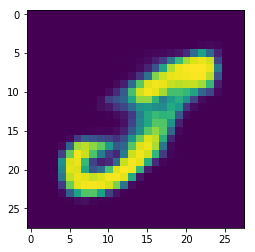

In [31]:
# Auxiliary Functions to plot 
def show(img):
    npimg = img.detach().numpy()
    plt.imshow(npimg, interpolation='nearest')
    
#Plot random decoded gaussian vector
show( vae_mnist_model_20.decode( torch.randn(20)).view(28,28) ) 

In [32]:
# Load test data
BATCH_SIZE = 32

## MNIST
mnist_test_loader = torch.utils.data.DataLoader(
                        datasets.MNIST('../data/mnist', train=False, transform=transforms.ToTensor()),
                        batch_size=BATCH_SIZE, shuffle=True)

## FASHION
mnist_test_loader = torch.utils.data.DataLoader(
                        datasets.MNIST('../data/mnist', train=False, transform=transforms.ToTensor()),
                        batch_size=BATCH_SIZE, shuffle=True)

# Loss functions
def loss_vae(x, recon_x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average = False)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def loss_vsc(alpha):
    
    def loss_vsc_(x, recon_x,  mu, logvar, logspike):
        
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average = False)
        spyke = torch.clamp( logspike.exp() , 1e-6 , 1.0 - 1e-6 )
        PRIOR = -0.5 * torch.sum( spyke.mul(1 + logvar - mu.pow(2) - logvar.exp()))  + \
                torch.sum( (1-spyke).mul(torch.log((1-spyke)/(1 - alpha))) + \
                spyke.mul(torch.log(spyke/alpha) ) )
        return BCE + PRIOR
        
    return loss_vsc_

# VLB reporting
def vlb(model, test_loader, loss_function ):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            kwargs = model(data)
            test_loss += loss_function(data , *kwargs ).item()
    return test_loss / (i+1)

In [33]:
# Evaluate VLB  for each model 

## MNIST - VAE
mnist_vae_vlb = []
mnist_vae_vlb.append( vlb(vae_mnist_model_20, mnist_test_loader, loss_vae ) )
mnist_vae_vlb.append( vlb(vae_mnist_model_50, mnist_test_loader, loss_vae ) )
mnist_vae_vlb.append( vlb(vae_mnist_model_75, mnist_test_loader, loss_vae ) )
mnist_vae_vlb.append( vlb(vae_mnist_model_100, mnist_test_loader, loss_vae ) )
mnist_vae_vlb.append( vlb(vae_mnist_model_150, mnist_test_loader, loss_vae ) )
mnist_vae_vlb.append( vlb(vae_mnist_model_200, mnist_test_loader, loss_vae ) )

## MNIST - VSC - alpha = 0.5
mnist_vsc_vlb_05 = []
mnist_vsc_vlb_05.append( vlb(vsc_mnist_model_20_05, mnist_test_loader, loss_vsc(0.5) ) )
mnist_vsc_vlb_05.append( vlb(vsc_mnist_model_50_05, mnist_test_loader, loss_vsc(0.5) ) )
mnist_vsc_vlb_05.append( vlb(vsc_mnist_model_75_05, mnist_test_loader, loss_vsc(0.5) ) )
mnist_vsc_vlb_05.append( vlb(vsc_mnist_model_100_05, mnist_test_loader, loss_vsc(0.5) ) )
mnist_vsc_vlb_05.append( vlb(vsc_mnist_model_150_05, mnist_test_loader, loss_vsc(0.5) ) )
mnist_vsc_vlb_05.append( vlb(vsc_mnist_model_200_05, mnist_test_loader, loss_vsc(0.5) ) )


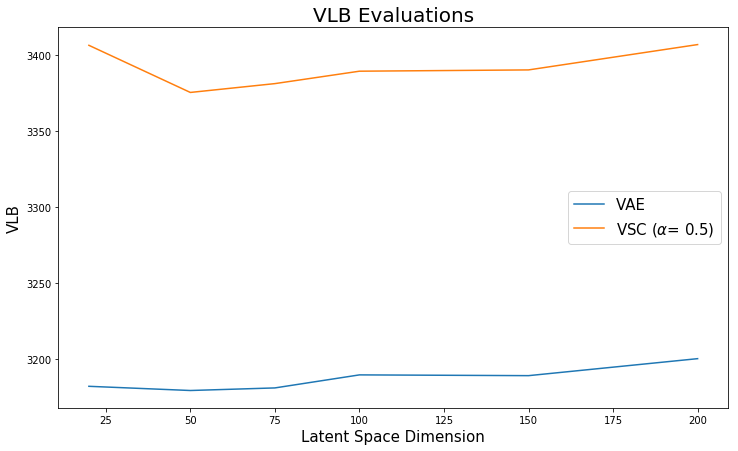

In [34]:
# Plot VLB evaluations
x = [20, 50, 75, 100, 150, 200  ]
plt.figure(figsize = (12, 7))
plt.title('VLB Evaluations', fontsize = 20 )
plt.plot( x , mnist_vae_vlb, label = 'VAE' )
plt.plot( x , mnist_vsc_vlb_05, label = r'VSC ($\alpha$= 0.5)' )
plt.ylabel('VLB', fontsize = 15)
plt.xlabel('Latent Space Dimension', fontsize = 15)
plt.legend(loc='best', fontsize = 15)